In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [2]:
data = pd.read_parquet(Path("data") / "train.parquet")
data.head(2)

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147


In [3]:
data_ext = pd.read_csv("external_data/external_data.csv", parse_dates=["date"])
data_ext.head(2)

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4
0,7149,2021-01-01 00:00:00,100810,80,1,270,1.8,272.75,272.15,96,...,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7149,2021-01-01 03:00:00,100920,110,3,300,1.7,271.25,270.95,98,...,1500.0,2.0,3.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN


Let's merge these two datasets:

In [13]:
columns_to_merge = ["date", "t", "rr6", "ff", "vv", "rr1", "rr3"]

In [14]:
def _merge_external_data(X):
    df_ext = pd.read_csv("external_data/external_data.csv", parse_dates=["date"])
    df_ext["date"] = df_ext["date"].astype('datetime64[us]')
    X = X.copy()
    # When using merge_asof left frame need to be sorted
    X["orig_index"] = np.arange(X.shape[0])
    X = pd.merge_asof(
        X.sort_values("date"), df_ext[columns_to_merge].sort_values("date"), on="date"
    )
    # Sort back to the original order
    X = X.sort_values("orig_index")
    del X["orig_index"]
    return X

In [15]:
data_m = _merge_external_data(data)
data_m.head(2)

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count,t,rr6,ff,vv,rr1,rr3
107,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,285.75,0.0,1.6,30000,0.0,0.0
153,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147,283.95,0.0,1.1,25000,0.0,0.0


In [16]:
data_f = data_m[columns_to_merge + ["log_bike_count"] + ["counter_name"]]

In [17]:
data_f.head(2)

,date,t,rr6,ff,vv,rr1,rr3,log_bike_count,counter_name
107,2020-09-01 02:00:00,285.75,0.0,1.6,30000,0.0,0.0,0.000000,28 boulevard Diderot E-O
153,2020-09-01 03:00:00,283.95,0.0,1.1,25000,0.0,0.0,0.693147,28 boulevard Diderot E-O


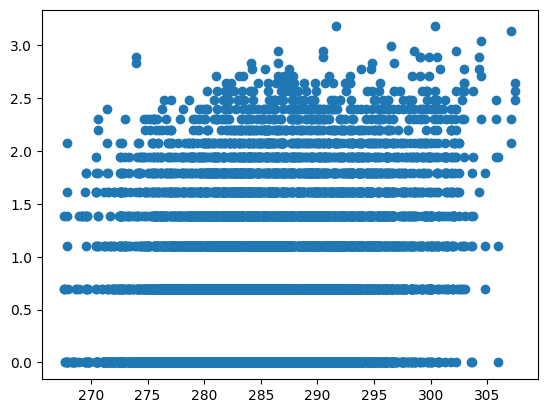

In [122]:
mask = data_f["counter_name"] == "28 boulevard Diderot E-O"
plt.scatter(data_f[mask]["t"], data_f[mask]["log_bike_count"])

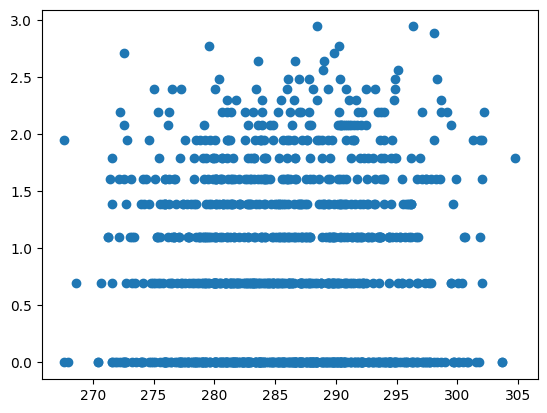

In [125]:
plt.scatter(data_f[mask].sample(n=1000)["t"], data_f[mask].sample(n=1000)["log_bike_count"])

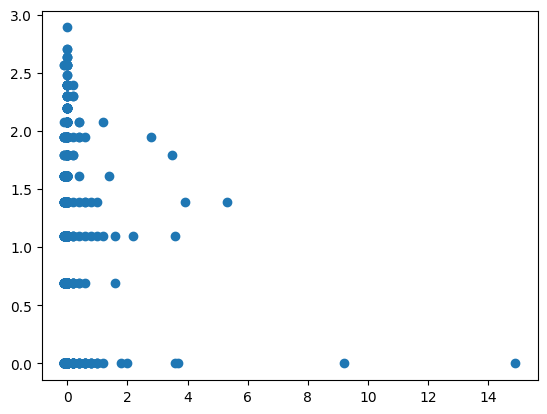

In [126]:
plt.scatter(data_f[mask].sample(n=1000)["rr1"], data_f[mask].sample(n=1000)["log_bike_count"])

<Axes: >

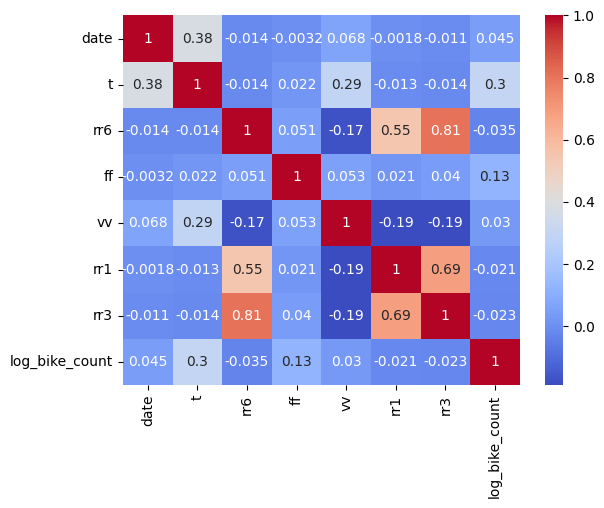

In [18]:
sns.heatmap(data_f.drop(columns="counter_name").corr(), annot=True, cmap='coolwarm')

In [19]:
# Filter the data for the specific counter name
mask = data_f["counter_name"] == "28 boulevard Diderot E-O"
filtered_data = data_f[mask]

In [20]:
data_f.isnull().mean() * 100

date              0.000000
t                 0.000000
rr6               0.403360
ff                0.000000
vv                0.000000
rr1               0.270517
rr3               0.135258
log_bike_count    0.000000
counter_name      0.000000
dtype: float64

In [21]:
data_f = data_f.dropna()

In [22]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

In [23]:
from sklearn.preprocessing import FunctionTransformer

date_encoder = FunctionTransformer(_encode_dates, validate=False)

In [24]:
def get_train_data(X):
    # Sort by date first, so that time based cross-validation would produce correct results
    X = X.sort_values(["date", "counter_name"])
    y_array = X["log_bike_count"].values
    X_df = X.drop(["log_bike_count"], axis=1)
    return X_df, y_array

In [25]:
X, y = get_train_data(data_f)

In [26]:
X.head(2)

,date,t,rr6,ff,vv,rr1,rr3,counter_name
20,2020-09-01 01:00:00,285.75,0.0,1.6,30000,0.0,0.0,152 boulevard du Montparnasse E-O
8,2020-09-01 01:00:00,285.75,0.0,1.6,30000,0.0,0.0,152 boulevard du Montparnasse O-E


Timestamp('2021-09-09 23:00:00')

In [27]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [28]:
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)

Train: n_samples=454671,  2020-09-01 01:00:00 to 2021-08-10 23:00:00
Valid: n_samples=39648,  2021-08-11 00:00:00 to 2021-09-09 23:00:00


In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

date_encoder = FunctionTransformer(_encode_dates)
date_cols = _encode_dates(X_train[["date"]]).columns.tolist()

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name"]

numerical_encoder = StandardScaler()
numerical_cols = ["ff", "t", "rr6"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("cat", categorical_encoder, categorical_cols),
        ("num", numerical_encoder, numerical_cols),
    ]
)

regressor = Ridge()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x000001476305FA60>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name']),
                                                 ('num', StandardScaler(),
                                                  ['ff', 't', 'rr6'])])),
                ('ridge', Ridge())])

In [30]:
from sklearn.metrics import mean_squared_error

print(
    f"Train set, RMSE={mean_squared_error(y_train, pipe.predict(X_train), squared=False):.2f}"
)
print(
    f"Valid set, RMSE={mean_squared_error(y_valid, pipe.predict(X_valid), squared=False):.2f}"
)

Train set, RMSE=0.79
Valid set, RMSE=0.73


C:\Users\willi\OneDrive\Bureau\X-HEC\Python projects\Kaggle_challenge\bike_counters\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\willi\OneDrive\Bureau\X-HEC\Python projects\Kaggle_challenge\bike_counters\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [31]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={mean_squared_error(y_train, np.full(y_train.shape, y_train.mean()), squared=False):.2f}"
)
print(
    f"Test set, RMSE={mean_squared_error(y_valid, np.full(y_valid.shape, y_valid.mean()), squared=False):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44


C:\Users\willi\OneDrive\Bureau\X-HEC\Python projects\Kaggle_challenge\bike_counters\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\willi\OneDrive\Bureau\X-HEC\Python projects\Kaggle_challenge\bike_counters\venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [32]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.95227426 -0.89084162 -0.85828121 -0.85615212 -1.02438422 -0.92227016]
RMSE (all folds): 0.917 ± 0.0586
